In [197]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as npm

## Collect data and create Dataset`

In [8]:
IMAGE_DIRECTORY = 'PlantVillage'

In [12]:
IMG_SIZE = 256
BATCH_SIZE = 32

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_DIRECTORY,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [17]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [23]:
# check one batch
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Image batch size: (32, 256, 256, 3)
Batch labels: [0 2 1 2 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 2]
First image: shape= (256, 256, 3), type= <class 'tensorflow.python.framework.ops.EagerTensor'>


2024-04-28 19:16:39.276757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


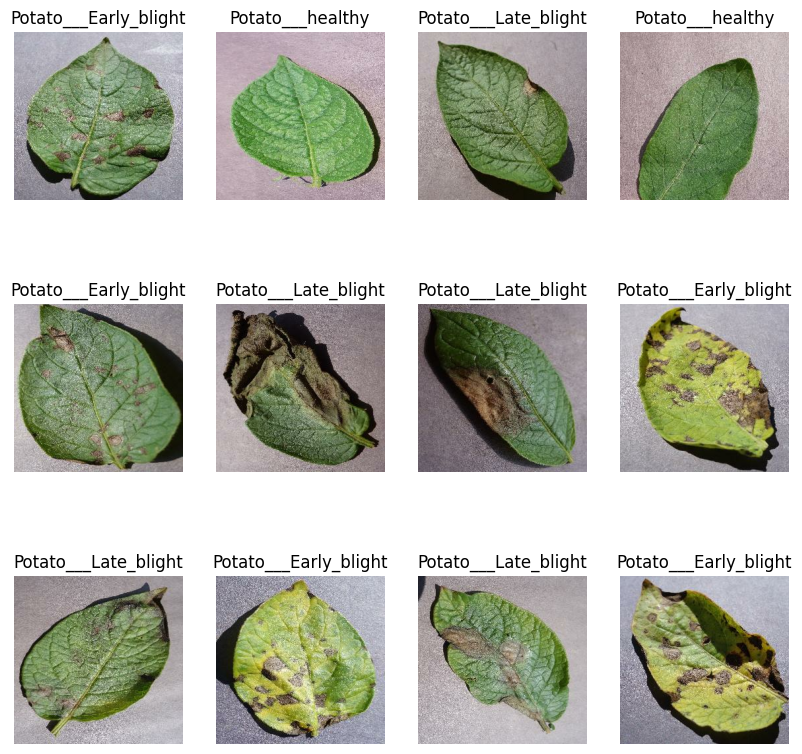

In [48]:
# check the batch size, 32 images of size (256 x 256) and 3 channels
plt.figure(figsize=(10, 10))

for image_batch, label_batch in dataset.take(1):
    print(f'Image batch size: {image_batch.shape}')
    print(f'Batch labels: {label_batch.numpy()}')
    print(f'First image: shape= {image_batch[0].shape}, type= {type(image_batch[0])}')

    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.title(class_names[label_batch.numpy()[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')

In [54]:
def get_train_test_split(ds, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    dataset_size = len(ds)

    if shuffle:
        ds.shuffle(shuffle_size, seed=7)
        
    train_size = int(dataset_size * train_size)
    val_size = int(dataset_size * val_size)
    test_size = int(dataset_size * test_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
    

In [55]:
train_ds, val_ds, test_ds = get_train_test_split(dataset)
print(f'Training dataset size: {len(train_ds)}')
print(f'Validation dataset size: {len(val_ds)}')
print(f'Test dataset size: {len(test_ds)}')

Training dataset size: 54
Validation dataset size: 6
Test dataset size: 8


In [139]:
# if we use prefetch(), when GPU will be training a batch then CPU will fetch a different batch for processing (without sitting idle)
# if we use cache(), images will be cached for processing in multiple EPOCHS

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Create and run the Model

In [146]:
# Create resize and rescale layers

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
], name='resize_and_rescale')

In [147]:
# Create data augmentation layers
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
], name='data_augmentation')

In [148]:
CHANNELS = 3
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
num_classes = len(class_names)

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name='Conv2D_1', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2,2), name='MaxPool2D_1'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='Conv2D_2'),
    tf.keras.layers.MaxPooling2D((2,2), name='MaxPool2D_2'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='Conv2D_3'),
    tf.keras.layers.MaxPooling2D((2,2), name='MaxPool2D_3'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='Conv2D_4'),
    tf.keras.layers.MaxPooling2D((2,2), name='MaxPool2D_4'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='Conv2D_5'),
    tf.keras.layers.MaxPooling2D((2,2), name='MaxPool2D_5'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='Conv2D_6'),
    tf.keras.layers.MaxPooling2D((2,2), name='MaxPool2D_6'),
    tf.keras.layers.Flatten(name='Flatten_Layer'),
    tf.keras.layers.Dense(64, activation='relu', name='Dense_1'),
    tf.keras.layers.Dense(num_classes, activation='softmax', name='Dense_2')
])

model.build(input_shape=input_shape)

In [149]:
model.summary()

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resize_and_rescale (Sequential) │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_1 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_1 (MaxPooling2D)      │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_2 (MaxPooling2D)      │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_3 (MaxPooling2D)      │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_4 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_4 (MaxPooling2D)      │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_5 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_5 (MaxPooling2D)      │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_6 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D_6 (MaxPooling2D)      │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
# compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
                                

In [151]:
EPOCHS = 30

history = model.fit(train_ds, 
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    batch_size=BATCH_SIZE,
                    verbose=1
                   )

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 767ms/step - accuracy: 0.4450 - loss: 0.9384 - val_accuracy: 0.5521 - val_loss: 0.9270
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 737ms/step - accuracy: 0.6226 - loss: 0.7455 - val_accuracy: 0.7552 - val_loss: 0.6045
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 682ms/step - accuracy: 0.8292 - loss: 0.4114 - val_accuracy: 0.8698 - val_loss: 0.3275
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 685ms/step - accuracy: 0.8957 - loss: 0.2623 - val_accuracy: 0.9062 - val_loss: 0.2911
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 669ms/step - accuracy: 0.9340 - loss: 0.1807 - val_accuracy: 0.9219 - val_loss: 0.2536
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 710ms/step - accuracy: 0.9367 - loss: 0.1609 - val_accuracy: 0.9115 - val_loss: 0.2449
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 668ms/step - accuracy: 0.9421 - loss: 0.1513 - val_accuracy: 0.8958 - val_loss: 0.2716
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 680ms/step - accuracy: 0.9443 - loss: 0.1430 - val_accu

## Evaluate the Model

In [160]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.9734 - loss: 0.1119


[0.11028986424207687, 0.9741379022598267]

In [164]:
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

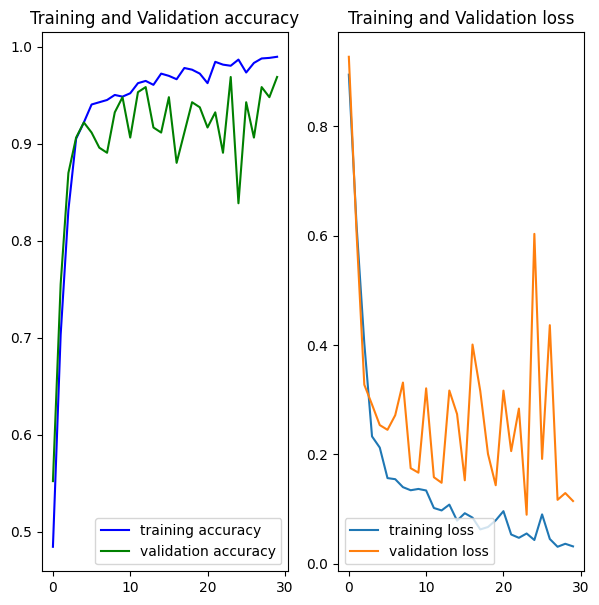

In [182]:
plt.figure(figsize=(7, 7))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), training_accuracy, color='blue', label='training accuracy')
plt.plot(range(EPOCHS), validation_accuracy, color='green', label='validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), training_loss, label='training loss')
plt.plot(range(EPOCHS), validation_loss, label='validation loss')
plt.legend(loc='lower left')
plt.title('Training and Validation loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


2024-04-28 22:45:21.241768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


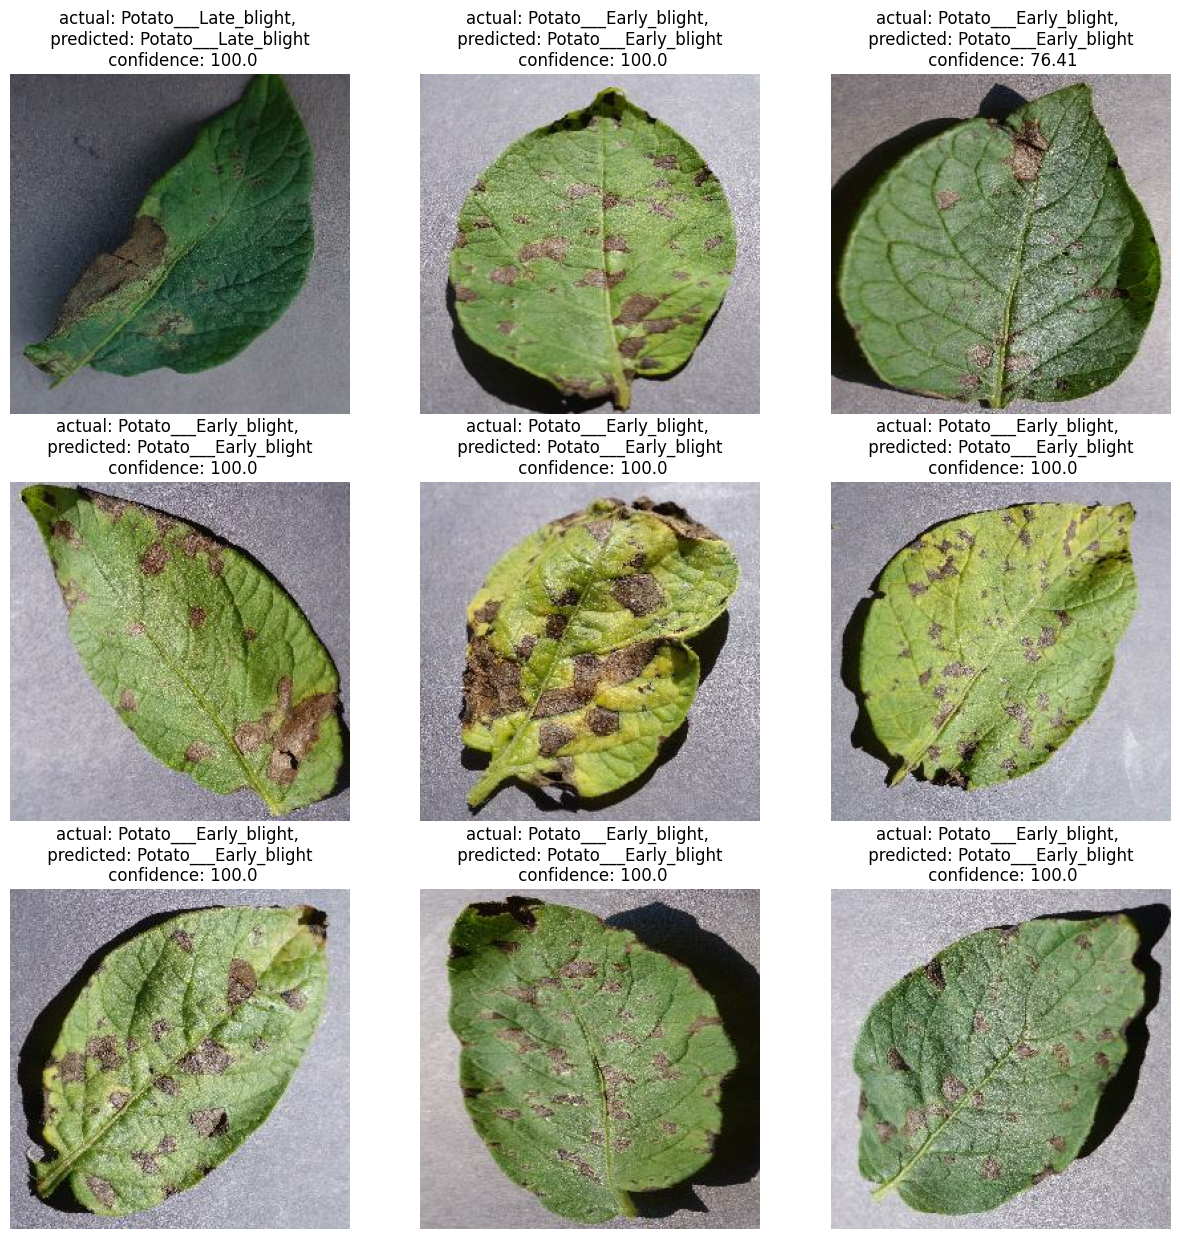

In [228]:
# Do some testing with the testing images

plt.figure(figsize=(15, 15))
for image_batch, label_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        actual_label = class_names[label_batch[i].numpy()]
        predicted_label = class_names[np.argmax(model.predict(image_batch)[i])]
        prediction_confidence =  round(np.max(model.predict(image_batch)[i]) * 100, 2)
        plt.title(f'actual: {actual_label}, \n predicted: {predicted_label} \n confidence: {prediction_confidence}')
        plt.axis('off')

In [236]:
# create a method where given the model and an image will predict the label

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)
    predicted_label = class_names[np.argmax(model.predict(image_batch)[i])]
    prediction_confidence =  round(np.max(model.predict(image_batch)[i]) * 100, 2)
    return predicted_label, prediction_confidence
    

In [237]:
predict(model, image_batch[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


('Potato___Early_blight', 100.0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/

2024-04-28 22:55:58.647627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


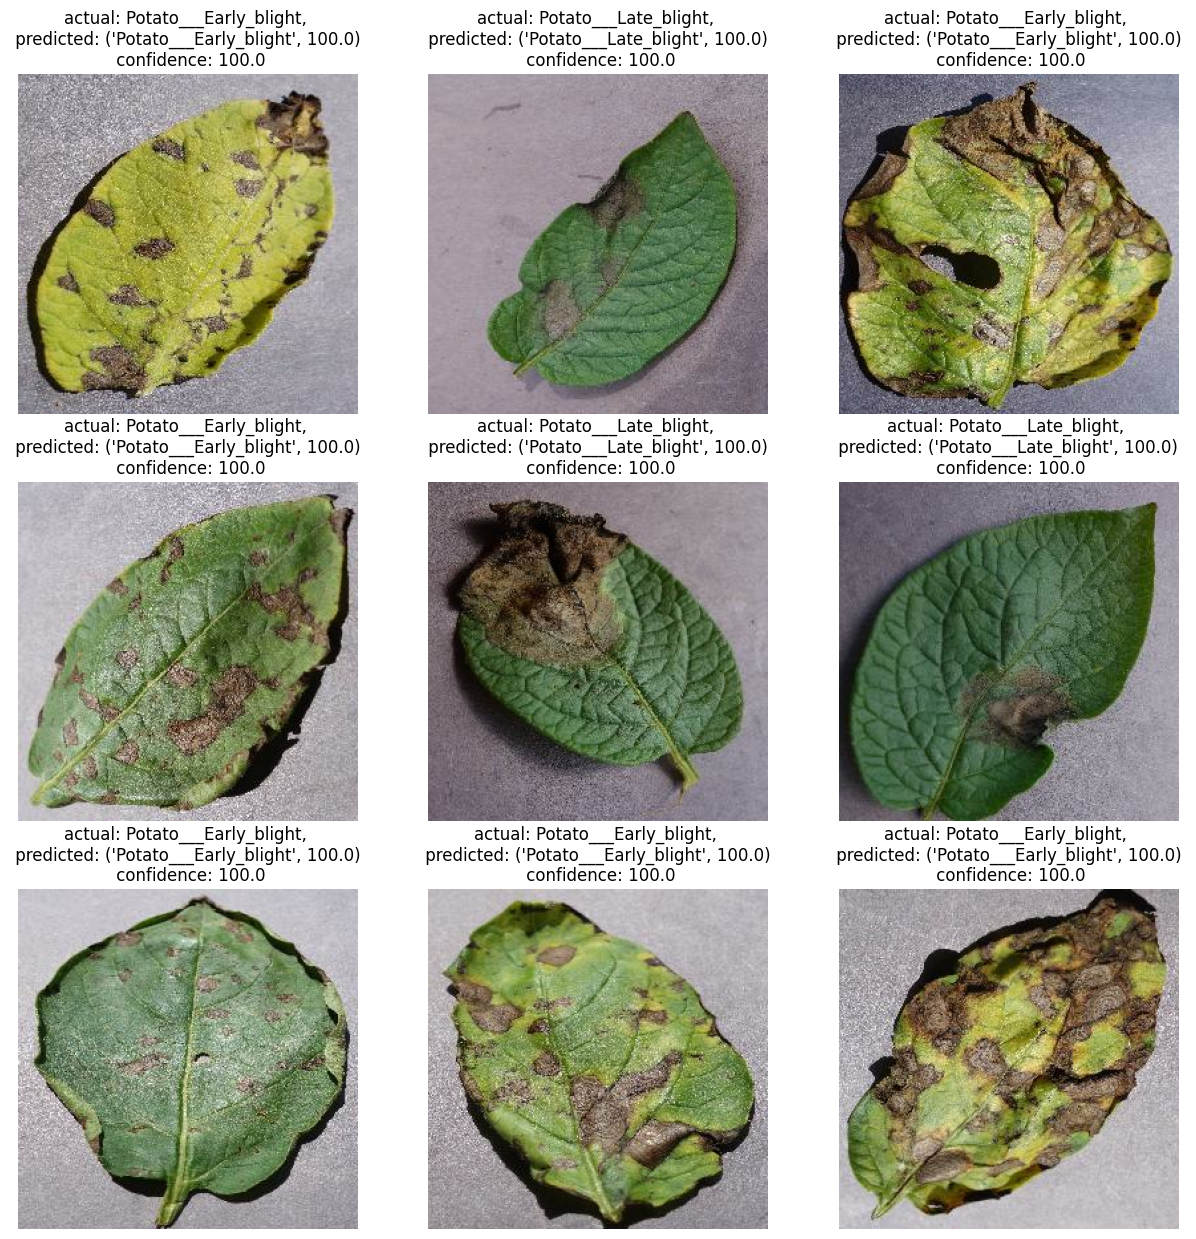

In [238]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        actual_label = class_names[label_batch[i].numpy()]
        predicted_label = predict(model, image_batch[i])
        plt.title(f'actual: {actual_label}, \n predicted: {predicted_label} \n confidence: {prediction_confidence}')
        plt.axis('off')

In [250]:
!mkdir models

mkdir: models: File exists


## Save the Model

In [267]:
# check the latest model version existing

import os

model_version = max([int(os.path.splitext(x)[0]) for x in os.listdir('models') + [str(0)]]) + 1

1

In [268]:

model_name = f'models/{model_version}.keras'
print(model_name)
model.save(model_name)

models/1.keras
